In [14]:
opt = {
    outchan = 3,
    inchan = 3,
    num_frames = 3,
    num_epoch = 10000,
    batchsize = 128,
    gpu = false
}

In [15]:
function string:split( inSplitPattern, outResults )
  if not outResults then
    outResults = { }
  end
  local theStart = 1
  local theSplitStart, theSplitEnd = string.find( self, inSplitPattern, 
theStart )
  while theSplitStart do
    table.insert( outResults, string.sub( self, theStart, theSplitStart-1 ) )
    theStart = theSplitEnd + 1
    theSplitStart, theSplitEnd = string.find( self, inSplitPattern, theStart )
  end
  table.insert( outResults, string.sub( self, theStart ) )
  return outResults
end

In [16]:
image = require 'image'

if opt.gpu then
    require 'cutorch'
    require 'cunn'
else
    inputdir = '/home/nicholas/Documents/small_faces/'
    truthdir = '/home/nicholas/Documents/big_faces/'
    inputvaldir = '/home/nicholas/Documents/small_val/'
    truthvaldir = '/home/nicholas/Documents/big_val/'
end

invidnames = {}
input_imgs = torch.FloatTensor()
label_imgs = torch.FloatTensor()
valimgs = torch.FloatTensor()
vallabels = torch.FloatTensor()

for file in paths.files('./') do
    if file:find('invidnames.t7' .. '$') then
        invidnames = torch.load('invidnames.t7')
    end
    if file:find('input_imgs.t7' .. '$') then
        input_imgs = torch.load('input_imgs.t7')
    end
    if file:find('label_imgs.t7' .. '$') then
        label_imgs = torch.load('label_imgs.t7')
    end
    if file:find('valvidnames.t7' .. '$') then
        invidnames = torch.load('invidnames.t7')
    end
    if file:find('valimgs.t7' .. '$') then
        valimgs = torch.load('valimgs.t7')
    end
    if file:find('vallabels.t7' .. '$') then
        vallabels = torch.load('vallabels.t7')
    end
end

if input_imgs:nDimension() == 0 then
    print('Loading all images from files')
    inputfiles = {}
    labelfiles = {}
    inputvalfiles = {}
    truthvalfiles = {}
    
    numTraining = 0
    numVal = 0
    
    for file in paths.files(inputdir) do
       if file:find('png' .. '$') then
        table.insert(inputfiles, paths.concat(inputdir,file))
        numTraining = numTraining + 1
       end
    end
    for file in paths.files(truthdir) do
       if file:find('png' .. '$') then
        table.insert(labelfiles, paths.concat(truthdir,file))
       end
    end
    for file in paths.files(inputvaldir) do
       if file:find('png' .. '$') then
        table.insert(inputvalfiles, paths.concat(inputvaldir,file))
        numVal = numVal + 1
       end
    end
    for file in paths.files(truthvaldir) do
       if file:find('png' .. '$') then
        table.insert(truthvalfiles, paths.concat(truthvaldir,file))
       end
    end


    -- Check files
    if #inputfiles == 0 or #labelfiles == 0 then
       error('given directory doesnt contain any files')
    end
    table.sort(inputfiles, function (a,b) return a < b end)
    table.sort(labelfiles, function (a,b) return a < b end)
    table.sort(inputvalfiles, function (a,b) return a < b end)
    table.sort(truthvalfiles, function (a,b) return a < b end)

    invidnames = {}
    input_imgs = torch.FloatTensor(numTraining, opt.inchan, 16, 16)
    label_imgs = torch.FloatTensor(numTraining, opt.outchan, 32, 32)

    for i,file in ipairs(inputfiles) do 
       input_imgs[i] = image.load(file)
       table.insert(invidnames, file:split('%.')[1])
    end

    for i,file in ipairs(labelfiles) do 
       label_imgs[i] = image.load(file)
    end

    -- construct validation set
    valvidnames = {}
    valimgs = torch.FloatTensor(numVal, opt.inchan, 16, 16)
    vallabels = torch.FloatTensor(numVal, opt.outchan, 32, 32)

    for i,file in ipairs(inputvalfiles) do 
       valimgs[i] = image.load(file)
       table.insert(valvidnames, file:split('%.')[1])
    end
    for i,file in ipairs(truthvalfiles) do 
       vallabels[i] = image.load(file)
    end

    torch.save('invidnames.t7', invidnames)
    torch.save('input_imgs.t7', input_imgs)
    torch.save('label_imgs.t7', label_imgs)
    torch.save('valvidnames.t7', valvidnames)
    torch.save('valimgs.t7', valimgs)
    torch.save('vallabels.t7', vallabels)
end

if opt.gpu then
    input_imgs = input_imgs:cuda()
    label_imgs = label_imgs:cuda()
    valimgs = valimgs:cuda()
    vallabels = vallabels:cuda()
end

print('Images loaded')

Loading all images from files	


Images loaded	


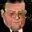

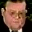

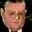

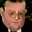

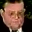

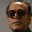

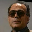

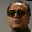

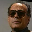

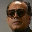

In [17]:
if not opt.gpu then
    for i = 1,5 do
       itorch.image(input_imgs[i])
    end
    for i = 1,5 do
       itorch.image(label_imgs[i])
    end
    for i = 1,5 do
       itorch.image(valimgs[i])
    end
    for i = 1,5 do
       itorch.image(vallabels[i])
    end
end
for i = 1,10 do
   image.save(('validation/val_img_%d_input.png'):format(i), valimgs[i])
   image.save(('validation/val_img_%d_label.png'):format(i), vallabels[i])
end

In [18]:
require 'nn'

-- input: inchan x 16 x 16
gen = nn.Sequential()
-- gen:add(nn.SpatialFullConvolution(opt.inchan, opt.outchan * 4, 9, 9))
-- gen:add(nn.SpatialBatchNormalization(opt.outchan * 4)):add(nn.ReLU(true))

-- -- size: opt.outchan * 4 x 24 x 24 
-- gen:add(nn.SpatialFullConvolution(opt.outchan * 4, opt.outchan, 9, 9))
-- gen:add(nn.ReLU(true))  

-- -- size: opt.outchan x 32 x 32

gen:add(nn.SpatialFullConvolution(opt.inchan * opt.num_frames, opt.outchan * 8, 3, 3))
gen:add(nn.SpatialBatchNormalization(opt.outchan * 8)):add(nn.ReLU(true))
-- -- size: opt.outchan * 8 x 18 x 18 

gen:add(nn.SpatialFullConvolution(opt.outchan * 8, opt.outchan * 4, 7, 7))
gen:add(nn.SpatialBatchNormalization(opt.outchan * 4)):add(nn.ReLU(true))
-- size: opt.outchan * 4 x 24 x 24 

gen:add(nn.SpatialFullConvolution(opt.outchan * 4, opt.outchan, 9, 9))
gen:add(nn.ReLU(true))  
-- size: opt.outchan x 32 x 32

if opt.gpu then
    gen:cuda()
end

In [31]:
-- generate validation set
valinputs = torch.FloatTensor(19952, opt.inchan * opt.num_frames, 16, 16)
valtruths = torch.FloatTensor(19952, opt.inchan, 32, 32)

for vi = 1, numVal do
    local rand_id = torch.random(2, valimgs:size(1) - 1)
    if valvidnames[rand_id]:split(1)[1] == valvidnames[rand_id - 1]:split(1)[1] and valvidnames[rand_id]:split(1)[1] == valvidnames[rand_id + 1]:split(1)[1] then
        valinputs[vi] = torch.cat(valimgs[rand_id - 1], valimgs[rand_id], 1):cat(valimgs[rand_id + 1], 1)
        valtruths[vi] = vallabels[rand_id]
    end
end

In [43]:
require 'optim'

-- collectgarbage('setstepmul', 120)
criterion = nn.AbsCriterion()
if opt.gpu then
    criterion:cuda()
end
local optimState = {learningRate = 0.001}

epoch_tm = torch.Timer()
total_tm = torch.Timer()
for epoch = 1, opt.num_epoch do
    
    -- construct batch
    inputs = torch.FloatTensor(opt.batchsize, opt.inchan * opt.num_frames, 16, 16)
    labels = torch.FloatTensor(opt.batchsize, opt.outchan, 32, 32)
    if opt.gpu then
        inputs = input:cuda()
        labels = labels:cuda()
    end
    bi = 0
    while bi < opt.batchsize do
        local rand_id = torch.random(2, input_imgs:size(1) - 1)
        if invidnames[rand_id]:split(1)[1] == invidnames[rand_id - 1]:split(1)[1] and invidnames[rand_id]:split(1)[1] == invidnames[rand_id + 1]:split(1)[1] then
            inputs[bi] = torch.cat(input_imgs[rand_id - 1], input_imgs[rand_id], 1):cat(input_imgs[rand_id + 1], 1)
            labels[bi] = label_imgs[rand_id]
            bi = bi + 1
        end
    end
    
    params, gradParams = gen:getParameters()
    
    -- evaluation, forwards/backward pass
    fGx = function(params)
        gradParams:zero()
        outputs = gen:forward(inputs)

        errG = criterion:forward(outputs, labels)
        df_do = criterion:backward(outputs, labels)
--         df_dg = disc:updateGradInput(inputs, df_do) -- when discriminator is implemented
        gen:backward(inputs, df_do)
        return errG, gradParams
    end
    
    -- train
    optim.adam(fGx, params, optimState)
    
    -- validate
    if epoch % 200 == 0 then
        outputs = gen:forward(valinputs)
        if not opt.gpu then
            for vi = 1, 4 do
                itorch.image(valinputs[vi])
                itorch.image(outputs[vi])
                itorch.image(image.scale(valinputs[vi], 64, 64, 'simple'))
                itorch.image(image.scale(outputs[vi], 64, 64, 'simple'))
            end
        end
        valerr = criterion:forward(outputs, valtruths)
        print(('\nvalidation error at epoch = %d is %.4f \t Time Taken: %.3f'):format(epoch, valerr, epoch_tm:time().real))
        
--         collectgarbage()
        epoch_tm:reset()
    end
end
print(('\n total time taken: %.3f'):format(total_tm:time().real))
gen:float()
torch.save('srez_model.t7', gen)

(1,.,.) = 
 Columns 1 to 9
  0.8039  0.8118  0.8039  0.8235  0.6118  0.3020  0.2196  0.2549  0.2863
  0.8039  0.8078  0.8157  0.8078  0.4706  0.2980  0.3529  0.3647  0.3294
  0.8039  0.8157  0.8157  0.6980  0.4196  0.5059  0.6039  0.6196  0.5529
  0.7922  0.8039  0.8039  0.5882  0.4980  0.6000  0.6549  0.6588  0.6941
  0.8078  0.8157  0.7686  0.5412  0.5373  0.6353  0.6549  0.6784  0.6863
  0.8000  0.8235  0.7686  0.5529  0.5843  0.6549  0.7020  0.7137  0.7294
  0.8157  0.8196  0.7294  0.5725  0.6078  0.6314  0.6118  0.6000  0.6431
  0.8471  0.7961  0.6549  0.5765  0.6431  0.6314  0.5176  0.4784  0.5451
  0.8392  0.8392  0.7176  0.5882  0.6314  0.6745  0.6314  0.6000  0.6314
  0.8118  0.8078  0.7176  0.6235  0.6392  0.6980  0.7098  0.6863  0.6745
  0.8000  0.7922  0.7216  0.6353  0.6353  0.6196  0.6275  0.6471  0.6588
  0.7843  0.7765  0.7294  0.6863  0.6471  0.5882  0.6000  0.6118  0.6118
  0.7725  0.7529  0.7020  0.7216  0.6588  0.5843  0.5882  0.5804  0.5647
  0.7725  0.8275  0.7647

bad argument #3 to '?' (out of range at /home/nicholas/torch/pkg/torch/lib/TH/generic/THTensor.c:359)
stack traceback:
	[C]: at 0x7f6039444150
	[C]: in function '__newindex'
	[string "require 'optim'..."]:28: in main chunk
	[C]: in function 'xpcall'
	/home/nicholas/torch/install/share/lua/5.1/itorch/main.lua:210: in function </home/nicholas/torch/install/share/lua/5.1/itorch/main.lua:174>
	/home/nicholas/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	.../nicholas/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	.../nicholas/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	.../nicholas/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/home/nicholas/torch/install/share/lua/5.1/itorch/main.lua:389: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00405d50: 

  0.3373  0.2353  0.1294  0.0863  0.1098
  0.4353  0.3451  0.3333  0.2118  0.1176  0.1412  0.1686
  0.2902  0.3059  0.3216  0.1529  0.1333  0.1412  0.1765

(3,.,.) = 
 Columns 1 to 9
  0.5922  0.6078  0.6000  0.6118  0.4000  0.0902  0.0078  0.0863  0.1176
  0.6000  0.6000  0.6078  0.5961  0.2588  0.0902  0.1451  0.1725  0.1608
  0.6000  0.5961  0.5961  0.4784  0.2000  0.2863  0.3843  0.4039  0.3608
  0.5765  0.5843  0.5725  0.3569  0.2549  0.3490  0.4039  0.4196  0.4549
  0.5922  0.5961  0.5373  0.3098  0.2941  0.3569  0.3765  0.4000  0.4078
  0.5843  0.6039  0.5373  0.3137  0.3373  0.3843  0.4039  0.4039  0.4039
  0.5922  0.5882  0.4863  0.3255  0.3490  0.3490  0.3020  0.2627  0.2941
  0.6235  0.5647  0.4157  0.3294  0.3843  0.3490  0.2196  0.1569  0.1961
  0.6157  0.6078  0.4784  0.3412  0.3725  0.4039  0.3490  0.2902  0.2980
  0.6196  0.5882  0.4863  0.3804  0.3843  0.4314  0.4235  0.3843  0.3608
  0.6078  0.5843  0.5020  0.4039  0.3922  0.3647  0.3490  0.3608  0.3608
  0.5725  0.56